# 1. Dataset load

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import norm, skew

# train / test set load
train = pd.read_csv("C:/ITWILL/4_Python-II/data/FIFA_train.csv")
test = pd.read_csv("C:/ITWILL/4_Python-II/data/FIFA_test.csv")

In [52]:
# dataset info
train.info() # (8932, 12)
test.info()  # (3828, 11)
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------      

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [53]:
# dataset check
train.head()

# 연속형 변수 / 범주형변수 분리
'''
연속형 변수 : 'age', , 'stat_overall', 'stat_potential'
범주형 변수 : 'continent', 'contract_until', 'position', 'prefer_foot', 'reputation'
'id', 'name', 'value', stat_skill_moves
'''
train.columns

train["stat_skill_moves"]

0       4.0
1       1.0
2       3.0
3       3.0
4       1.0
       ... 
8927    3.0
8928    2.0
8929    2.0
8930    1.0
8931    2.0
Name: stat_skill_moves, Length: 8932, dtype: float64

In [54]:
import re
train[["contract_until", "value"]].groupby("contract_until").count()

,value
contract_until,
2018,327
2019,2366
2020,2041
2021,2308
2022,761
2023,506
2024,12
2025,3
2026,1


In [55]:
comdata = pd.concat([train, test], ignore_index=True)

In [56]:
# contract_until 변수 전처리(월, 일 제거)
idx = []
for i, value in enumerate(comdata["contract_until"]):
    if re.match("[A-Z]{1,}", value):
        idx.append(i)
comdata["contract_until"][idx].replace("[A-Z]{1,}[a-z]{2}", "")

for i, j in zip(comdata["contract_until"][idx], idx):
    comdata["contract_until"][j] = re.sub("[A-Z]{1,}[a-z]{2} [0-9]{1,}, ", "", i).strip()
    
# 공백 제거
comdata.loc[:, "contract_until"] = comdata.loc[:, "contract_until"].str.strip()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


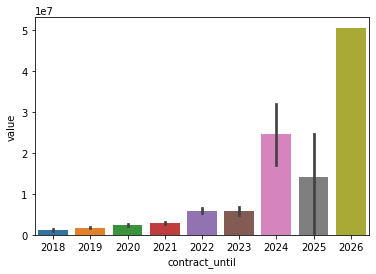

In [57]:
# contract_until 
# 변수에 따라 선수가치가 변하므로 사용!
sns.barplot(x = "contract_until", y = "value", data = comdata)

,value
continent,
africa,2.972247e+06
asia,1.035146e+06
europe,2.928125e+06
oceania,8.225429e+05
south america,3.183204e+06


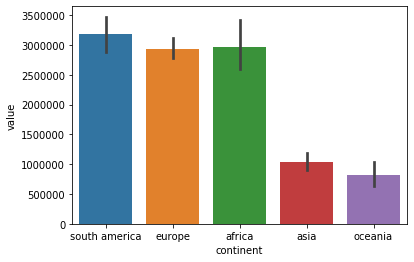

In [58]:
# continent
g = sns.barplot(x = "continent", y = "value", data = comdata)
comdata[["continent", "value"]].groupby(["continent"]).mean()

,value
position,
DF,2.304348e+06
GK,1.992073e+06
MF,3.121762e+06
ST,3.330361e+06


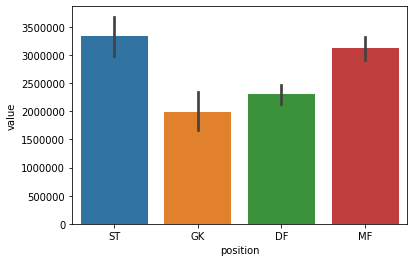

In [59]:
# position
g = sns.barplot(x = "position", y = "value", data = comdata)
comdata[["position", "value"]].groupby(["position"]).mean()

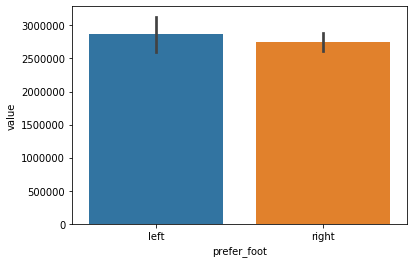

In [60]:
# prefer_foot
g = sns.barplot(x = "prefer_foot", y = "value", data = comdata)
comdata[["prefer_foot", "value"]].groupby(["prefer_foot"]).mean()

# ttest로 평균차이 확인
prefter_left = comdata.loc[comdata["prefer_foot"] == "left", "value"]
prefter_left = prefter_left.dropna()

prefter_right = comdata.loc[comdata["prefer_foot"] == "right", "value"]
prefter_right = prefter_right.dropna()

stats.ttest_ind(prefter_left, prefter_right)
# pvalue > 0.05, 왼발과 오른발에는 평균에는 차이가 없다
# 그럼므로 주사용 발에 따른 선수가치에는 차이가 없으므로 선수가치를 판단할때는 제거한다.
comdata = comdata.drop(["prefer_foot"], axis = 1)

                   value
reputation              
1.0         1.690092e+06
2.0         8.639221e+06
3.0         2.201483e+07
4.0         3.342903e+07
5.0         6.062500e+07
[5. 4. 3. 1. 2.]
count    12760.000000
mean         1.134796
std          0.431366
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: reputation, dtype: float64


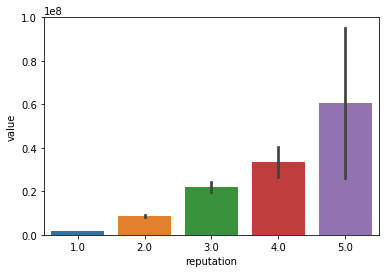

In [69]:
# reputation
g = sns.barplot(x = "reputation", y = "value", data = comdata)
print(comdata[["reputation", "value"]].groupby(["reputation"]).mean())
print(comdata["reputation"].unique())
print(comdata["reputation"].describe())

                         value
stat_skill_moves              
1.0               1.992073e+06
2.0               1.448798e+06
3.0               3.128878e+06
4.0               1.100068e+07
5.0               2.005161e+07
[4. 1. 3. 2. 5.]
count    12760.000000
mean         2.405643
std          0.777576
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: stat_skill_moves, dtype: float64


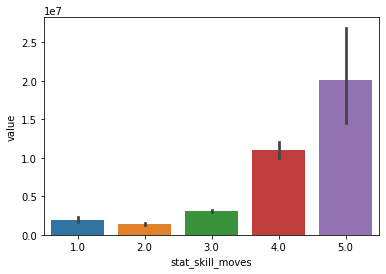

In [70]:
# stat_skill_moves
g = sns.barplot(x = "stat_skill_moves", y = "value", data = comdata)
print(comdata[["stat_skill_moves", "value"]].groupby(["stat_skill_moves"]).mean())
print(comdata["stat_skill_moves"].unique())
print(comdata["stat_skill_moves"].describe())

<Figure size 576x432 with 0 Axes>

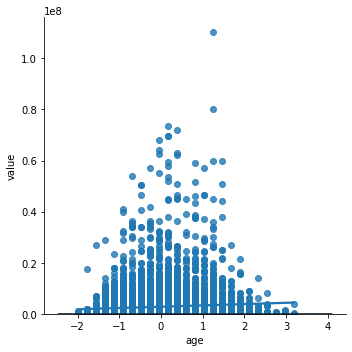

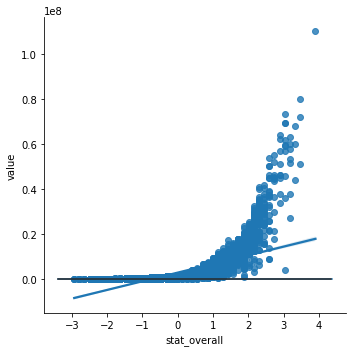

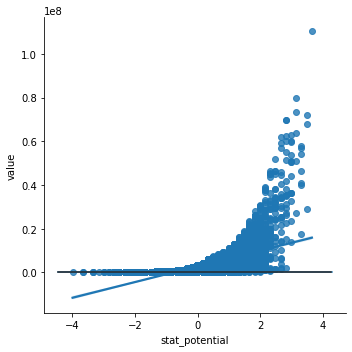

In [205]:
# 연속형변수 확인
# 'age', 'stat_overall', 'stat_potential'
# 스케일링
ind_idx_num = ['age', 'stat_overall', 'stat_potential']
de_idx = "value"
scaler = StandardScaler()
comdata[idx_num] = scaler.fit_transform(comdata[idx_num])


plt.figure(figsize  = (8, 6))
for i in ind_idx_num:
    sns.lmplot(x = i, y = "value", data = comdata)
    sns.distplot(comdata[i], fit = norm)


In [106]:
# One-Hot-encoding 더미변수 생성
comdata_dummies = pd.get_dummies(comdata.iloc[:, 2:])
print(comdata_dummies.shape) # (12760, 24)

# 데이터셋 분리
tr_data = comdata_dummies.iloc[:8932]
te_data = comdata_dummies.iloc[8932:]

(12760, 24)


In [113]:
# 독립변수, 종속변수 분리
col = tr_data.columns
y_col = "value"
x_col = [i for i in col if i != y_col]

# train /test set split
x_train, x_test, y_train, y_test = train_test_split(tr_data[x_col], tr_data[y_col], test_size = 0.3)

In [ ]:
# 기본 pipe 생성
pipe = Pipeline([("regressor", LinearRegression())])

# paramgrid
param_grid = [{"regressor":[LinearRegression()]},
             {"regressor":[RandomForestRegressor()], "regressor__n_estimators":[100,200,300,400],
             "regressor__max_depth":[3,6,8,10], "regressor__min_samples_split":[2,3,4,5], "regressor__min_samples_leaf": [1,3,5,7]},
             {"regressor":[XGBRegressor()], "regressor__colsample_bylevel":[0.6,0.8,1], "regressor__learning_rate":[0.01,0.1],
             "regressor__max_depth":[3,6,8,10], "regressor__min_child_weight":[1,3], "regressor__n_estimators":[100,200,300,400]}]


# eval_set = [(x_test, y_test)], eval_metric = "rmse", verbose = True
# eval_set : ensamble 모형에서 사용
gs = GridSearchCV(pipe, param_grid, cv = 5, n_jobs=-1)

model = gs.fit(x_train, y_train)

In [ ]:
# model score & best_parameter
print(model.best_score_)
print(model.best_estimator_)
y_pred = model.predict(x_test)
y_true = y_test
print(mean_squared_error(y_true, y_pred))

In [ ]:
# 중요변수 확인 : 
model.best_estimator_.named_steps["regressor"].feature_importances_
plt.figure(figsize = (20,5))
sns.barplot(x = list(range(23)), y = model.best_estimator_.named_steps["regressor"].feature_importances_)
plt.xticks(list(range(23)), x_train.columns)

In [ ]:
# 실제 데이터 예측
rel_y_pred = model.predict(te_data[x_col])
te_data

submit = pd.read_csv("c:/itwill/4_python-ii/data/submission.csv")
submit.info()
submit["value"] = rel_y_pred
submit.head()
submit.to_csv("c:/itwill/4_python-ii/data/submission.csv", index = None, encoding = "utf-8")

In [ ]:
lgb = LGBMRegressor()
train_ds = lgb.Dataset(x_train, label = y_train) 
test_ds = lgb.Dataset(x_test, label = y_test) 

param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

model = lgb.train(param_grid, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)